In [210]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

tqdm.pandas()

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
SEED = 23
data_dir = Path("../Daten/data_to_use")
unseen_data_dir = Path("../Daten/TUD")

## ML Configuration

In [201]:
conf_ML = [
    ('Dummy', DummyClassifier(), {'Dummy__strategy' : ["stratified"], 'Dummy__random_state': [SEED]}),
    ('Tree', DecisionTreeClassifier(), {'Tree__max_depth': range(1,10), 'Tree__random_state': [SEED]}),
    ('Forest', RandomForestClassifier(), {'Forest__max_depth': range(1,20), 'Forest__random_state': [SEED]}),
    ('GradientBoost', GradientBoostingClassifier(), {'GradientBoost__max_depth': range(1,10), 'GradientBoost__random_state': [SEED]}),
    ('MLP', MLPClassifier(), {'MLP__hidden_layer_sizes': range(1,20), "MLP__random_state": [SEED]}),
    ('Logistic', LogisticRegression(), {'Logistic__C':np.logspace(0,4, 10) ,'Logistic__random_state': [SEED]}),
    #('Poly_SVM', SVC(), {'Poly_SVM__C' : [1.0, 2.5, 5.0, 7.5, 10.0], 'Poly_SVM__kernel' : ['poly'], 'Poly_SVM__degree' : range(1,3), 'Poly_SVM__random_state': [SEED]}),
    ('SVM', SVC(), {'SVM__C' : np.logspace(0,4, 20), 'SVM__gamma': np.logspace(-1,1, 10), 'SVM__kernel' : ['rbf'], 'SVM__random_state': [SEED]})
]

In [202]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]

## Definitions

Function can still be changed such that full dataset is used in additional experiments

In [223]:
def prepare_data(name, features = features_ML, return_industry =False):
    
    #datanames = [ "brazil_gaz", "japan", "brazil", "ticino", "US"]
    
    #if name not in datanames + ["all"]:
        #print("This is not a dataset ")
        
    if type(name) == list:
    ##TODO: eventually use full dataset not only train here    
        data = []
        for ds in tqdm(name):
            if ds != "swissdata":
                df = pd.read_json(data_dir/f"{ds}_train.json")
            else:
                df = pd.read_json(data_dir/f"{ds}_train.json")
            if "ID" in df.keys():
                df.rename(columns = {"ID": "project"}, inplace = True)
            if "Price" in df.keys():
                df.rename(columns = {"Price": "bid"}, inplace = True)
            if "complete" in df.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                #df.rename(columns = {"complete": "cartel"}, inplace = True)#this option only considers complete cartels as cartels
                #df["cartel"] = df.complete | df.incomplete #this option also considers incomplete cartels as cartels
                df = df[df.incomplete!=1] #this option removes all incomplete cartels and does not consider them
                df.rename(columns = {"complete": "cartel"}, inplace = True)
                
            df["project"] = df.project.apply(lambda s: f"{ds}/{s}" )
            
            if return_industry:
                df["industry"] = ds
            
            data.append(df[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]]) #to make sure nbids is included as it will be needed later
        df = pd.concat(data)
        
        
        
    else:
        print("for this evaluation we need a list as input")
    
    df_grouped = df.groupby(by="project").head(1).reset_index()
    
    df_grouped.drop(columns=["bid"], inplace = True)
    df_grouped = df_grouped.merge(df.groupby(by="project")["bid"].apply(list), left_on = "project", right_on = "project")
    
    df_grouped["bid"] = df_grouped.bid.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped["bid"] = df_grouped.bid.apply(lambda x: np.sort(x)[::-1])
    
    padding_length = max(np.asarray(df_grouped.nbids.tolist()))
    df_grouped["bid"] = df_grouped.bid.apply(lambda x: np.pad(x, (0,padding_length-len(x))))
    
    df_grouped.dropna(inplace = True)
    
    X_DL = np.array(df_grouped.bid.tolist())
    X_DL = X_DL.reshape(X_DL.shape[0], X_DL.shape[1], 1)

    X = df_grouped[features]
    y = df_grouped["cartel"]
    
    return X,y, X_DL

In [6]:
def evaluate_models(X,y, configuration, SEED = SEED, print_full = False, LOO = False):
    model_scores = []
    models = []
    results = []
    full_results = []
    for name, algo, params in configuration:
        print(f'Trying {name} ...')
        # Extend model with normalisation step (here we use z-normalisation)
        #("scaler", StandardScaler()) # only needed in ML hyper parameter tuning
        pipeline = Pipeline([("scaler", StandardScaler()),(name, algo)])
        # Instantiate grid search object and pass params, number of folds and scoring-function
        if LOO:
            mycv = StratifiedKFold(n_splits = 10, random_state=SEED, shuffle = True) #not programmed yet
        else:
            mycv = StratifiedKFold(n_splits = 10, random_state=SEED, shuffle = True)
        classifier = GridSearchCV(pipeline, param_grid=params, cv= mycv, scoring=['f1', 'precision', 'recall', 'accuracy'], refit = 'f1', return_train_score = True)
        # Fit cross validation to our training data: within this function, all configurations are tried
        classifier.fit(X, y)
        print(f'  - Best hyperparameter: {classifier.best_params_}')
        print(f'  - Best F1 score: {classifier.best_score_:.3f}')
        if print_full:
            print(f'  - F1 Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_f1']])
            print(f'  - F1 Result for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_f1']])
            print(f'  - precision Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_precision']])
            print(f'  - precision for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_precision']])
            print(f'  - recall Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_recall']])
            print(f'  - recall Result for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_recall']])
            print(f'  - accuracy Result for each parametrization in train:', [f'{x:.2f}' for x in classifier.cv_results_['mean_train_accuracy']])
            print(f'  - accuracy Result for each parametrization in test:', [f'{x:.2f}' for x in classifier.cv_results_['mean_test_accuracy']])
        model_scores.append(classifier.best_score_)
        models.append(classifier.best_estimator_)
    
        index = classifier.best_index_
        df_results = pd.DataFrame({
            "algorithm": name,
            "train_f1": ["{:.3f}".format(classifier.cv_results_['mean_train_f1'][index])], "test_f1": ["{:.3f}".format(classifier.cv_results_['mean_test_f1'][index])],
            "train_precision": ["{:.3f}".format(classifier.cv_results_['mean_train_precision'][index])], "test_precision": ["{:.3f}".format(classifier.cv_results_['mean_test_precision'][index])],
            "train_recall": ["{:.3f}".format(classifier.cv_results_['mean_train_recall'][index])], "test_recall": ["{:.3f}".format(classifier.cv_results_['mean_test_recall'][index])],
            "train_accuracy": ["{:.3f}".format(classifier.cv_results_['mean_train_accuracy'][index])], "test_accuracy": ["{:.3f}".format(classifier.cv_results_['mean_test_accuracy'][index])],
            "params": [classifier.best_params_]
            })
        results.append(df_results)
    
        df_full_results = pd.DataFrame({
            "algorithm": name,
            "train_f1": classifier.cv_results_['mean_train_f1'], "test_f1": classifier.cv_results_['mean_test_f1'],
            "train_precision": classifier.cv_results_['mean_train_precision'], "test_precision": classifier.cv_results_['mean_test_precision'],
            "train_recall": classifier.cv_results_['mean_train_recall'], "test_recall": classifier.cv_results_['mean_test_recall'],
            "train_accuracy": classifier.cv_results_['mean_train_accuracy'], "test_accuracy": classifier.cv_results_['mean_test_accuracy'],
            "params": classifier.cv_results_["params"]
            })
        full_results.append(df_full_results)
    
    results = pd.concat(results)
    results = results.reset_index(drop = True)

    full_results = pd.concat(full_results)
    full_results = full_results.reset_index(drop = True)
    
    return results, full_results

# Train

We agreed on not using the incomplete cartels in the dataset. This training results will be labelled as comp for only using complete cartels.

## Experiment 4:

Ticino/Swiss/Japan zum trainieren, Brasilien Infrastruktur zum evaluieren

In [221]:
data_names = ["ticino", "swissdata", "japan"]

**With nbids**

In [224]:
X,y,_ = prepare_data(data_names)
results, full_results = evaluate_models(X, y, conf_ML, SEED = SEED)
results.to_json("MLresults/MLreanalysis/exp4_nbids_comp.json")
full_results.to_json("MLresults/MLreanalysis/exp4_nbids_fullresults_comp.json")

  0%|          | 0/3 [00:00<?, ?it/s]

Trying Dummy ...
  - Best hyperparameter: {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.318
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 7, 'Tree__random_state': 23}
  - Best F1 score: 0.748
Trying Forest ...
  - Best hyperparameter: {'Forest__max_depth': 12, 'Forest__random_state': 23}
  - Best F1 score: 0.777
Trying GradientBoost ...
  - Best hyperparameter: {'GradientBoost__max_depth': 6, 'GradientBoost__random_state': 23}
  - Best F1 score: 0.770
Trying MLP ...


/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum itera

  - Best hyperparameter: {'MLP__hidden_layer_sizes': 15, 'MLP__random_state': 23}
  - Best F1 score: 0.739
Trying Logistic ...
  - Best hyperparameter: {'Logistic__C': 2.7825594022071245, 'Logistic__random_state': 23}
  - Best F1 score: 0.610
Trying SVM ...
  - Best hyperparameter: {'SVM__C': 78.47599703514611, 'SVM__gamma': 0.46415888336127786, 'SVM__kernel': 'rbf', 'SVM__random_state': 23}
  - Best F1 score: 0.764


Results with only complete cartels:

In [225]:
results

algorithm train_f1 test_f1 train_precision test_precision train_recall  \
0          Dummy    0.342   0.318           0.356          0.341        0.330   
1           Tree    0.824   0.748           0.909          0.835        0.754   
2         Forest    0.980   0.777           0.999          0.850        0.961   
3  GradientBoost    0.989   0.770           0.996          0.825        0.981   
4            MLP    0.742   0.739           0.823          0.818        0.676   
5       Logistic    0.617   0.610           0.686          0.680        0.561   
6            SVM    0.815   0.764           0.912          0.856        0.736   

  test_recall train_accuracy test_accuracy  \
0       0.297          0.564         0.561   
1       0.681          0.889         0.844   
2       0.719          0.986         0.860   
3       0.724          0.992         0.852   
4       0.676          0.838         0.836   
5       0.556          0.760         0.756   
6       0.692          0.885         0.854   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 12, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 2.7825594022071245, 'Logistic_...  
6  {'SVM__C': 78.47599703514611, 'SVM__gamma': 0....

In [226]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm & train\_f1 & test\_f1 & train\_precision & test\_precision & train\_recall & test\_recall & train\_accuracy & test\_accuracy &                                             params \\
\midrule
        Dummy &    0.342 &   0.318 &           0.356 &          0.341 &        0.330 &       0.297 &          0.564 &         0.561 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree &    0.824 &   0.748 &           0.909 &          0.835 &        0.754 &       0.681 &          0.889 &         0.844 &   \{'Tree\_\_max\_depth': 7, 'Tree\_\_random\_state': 23\} \\
       Forest &    0.980 &   0.777 &           0.999 &          0.850 &        0.961 &       0.719 &          0.986 &         0.860 & \{'Forest\_\_max\_depth': 12, 'Forest\_\_random\_state... \\
GradientBoost &    0.989 &   0.770 &           0.996 &          0.825 &        0.981 &       0.724 &          0.992 &         0.852 & \{'GradientBoost\_\_max\_depth': 6, 'Gr

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_91140/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


results considering incomplete cartels as cartels

In [204]:
results

algorithm train_f1 test_f1 train_precision test_precision train_recall  \
0          Dummy    0.407   0.410           0.416          0.424        0.398   
1           Tree    0.808   0.675           0.892          0.743        0.740   
2         Forest    1.000   0.714           1.000          0.781        1.000   
3  GradientBoost    0.900   0.712           0.945          0.793        0.859   
4            MLP    0.688   0.686           0.783          0.784        0.613   
5       Logistic    0.568   0.568           0.641          0.643        0.510   
6            SVM    0.751   0.690           0.889          0.818        0.651   

  test_recall train_accuracy test_accuracy  \
0       0.396          0.530         0.537   
1       0.622          0.858         0.758   
2       0.658          1.000         0.787   
3       0.648          0.923         0.789   
4       0.613          0.774         0.774   
5       0.511          0.686         0.686   
6       0.599          0.826         0.783   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 9, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 18, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 5, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 59.94842503189409, 'Logistic__...  
6  {'SVM__C': 78.47599703514611, 'SVM__gamma': 0....

results considering incomplete cartels as competitiotn

In [23]:
results

algorithm train_f1 test_f1 train_precision test_precision train_recall  \
0          Dummy    0.327   0.327           0.334          0.346        0.321   
1           Tree    0.808   0.743           0.894          0.816        0.738   
2         Forest    0.873   0.762           0.961          0.856        0.800   
3  GradientBoost    0.876   0.763           0.946          0.855        0.815   
4            MLP    0.732   0.726           0.828          0.822        0.656   
5       Logistic    0.604   0.606           0.705          0.706        0.529   
6            SVM    0.817   0.756           0.924          0.860        0.732   

  test_recall train_accuracy test_accuracy  \
0       0.311          0.588         0.601   
1       0.686          0.891         0.854   
2       0.689          0.928         0.867   
3       0.690          0.928         0.867   
4       0.653          0.850         0.847   
5       0.534          0.784         0.785   
6       0.676          0.897         0.865   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 9, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 4, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 7.742636826811269, 'Logistic__...  
6  {'SVM__C': 1438.449888287663, 'SVM__gamma': 0....

In [24]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm & train\_f1 & test\_f1 & train\_precision & test\_precision & train\_recall & test\_recall & train\_accuracy & test\_accuracy &                                             params \\
\midrule
        Dummy &    0.327 &   0.327 &           0.334 &          0.346 &        0.321 &       0.311 &          0.588 &         0.601 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree &    0.808 &   0.743 &           0.894 &          0.816 &        0.738 &       0.686 &          0.891 &         0.854 &   \{'Tree\_\_max\_depth': 7, 'Tree\_\_random\_state': 23\} \\
       Forest &    0.873 &   0.762 &           0.961 &          0.856 &        0.800 &       0.689 &          0.928 &         0.867 & \{'Forest\_\_max\_depth': 9, 'Forest\_\_random\_state'... \\
GradientBoost &    0.876 &   0.763 &           0.946 &          0.855 &        0.815 &       0.690 &          0.928 &         0.867 & \{'GradientBoost\_\_max\_depth': 4, 'Gr

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_70727/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


**Without nbids**

In [25]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks"]

X,y, X_DL = prepare_data(data_names, features = features_ML)
results, full_results = evaluate_models(X, y, conf_ML, SEED = SEED)

results.to_json("MLresults/MLreanalysis/exp4.json")
full_results.to_json("MLresults/MLreanalysis/exp4_fullresults.json")

  0%|          | 0/3 [00:00<?, ?it/s]

Trying Dummy ...
  - Best hyperparameter: {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.327
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 7, 'Tree__random_state': 23}
  - Best F1 score: 0.681
Trying Forest ...
  - Best hyperparameter: {'Forest__max_depth': 18, 'Forest__random_state': 23}
  - Best F1 score: 0.728
Trying GradientBoost ...
  - Best hyperparameter: {'GradientBoost__max_depth': 6, 'GradientBoost__random_state': 23}
  - Best F1 score: 0.726
Trying MLP ...


/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum itera

  - Best hyperparameter: {'MLP__hidden_layer_sizes': 17, 'MLP__random_state': 23}
  - Best F1 score: 0.661
Trying Logistic ...
  - Best hyperparameter: {'Logistic__C': 1.0, 'Logistic__random_state': 23}
  - Best F1 score: 0.607
Trying SVM ...
  - Best hyperparameter: {'SVM__C': 10000.0, 'SVM__gamma': 0.2782559402207124, 'SVM__kernel': 'rbf', 'SVM__random_state': 23}
  - Best F1 score: 0.704


In [26]:
results

algorithm train_f1 test_f1 train_precision test_precision train_recall  \
0          Dummy    0.327   0.327           0.334          0.346        0.321   
1           Tree    0.769   0.681           0.842          0.746        0.710   
2         Forest    1.000   0.728           1.000          0.792        1.000   
3  GradientBoost    0.968   0.726           0.993          0.804        0.943   
4            MLP    0.666   0.661           0.728          0.723        0.613   
5       Logistic    0.610   0.607           0.697          0.698        0.542   
6            SVM    0.783   0.704           0.890          0.800        0.699   

  test_recall train_accuracy test_accuracy  \
0       0.311          0.588         0.601   
1       0.631          0.867         0.817   
2       0.676          1.000         0.844   
3       0.666          0.980         0.844   
4       0.611          0.808         0.806   
5       0.540          0.783         0.784   
6       0.631          0.879         0.835   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 18, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 17, 'MLP__random_s...  
5  {'Logistic__C': 1.0, 'Logistic__random_state':...  
6  {'SVM__C': 10000.0, 'SVM__gamma': 0.2782559402...

In [27]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm & train\_f1 & test\_f1 & train\_precision & test\_precision & train\_recall & test\_recall & train\_accuracy & test\_accuracy &                                             params \\
\midrule
        Dummy &    0.327 &   0.327 &           0.334 &          0.346 &        0.321 &       0.311 &          0.588 &         0.601 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree &    0.769 &   0.681 &           0.842 &          0.746 &        0.710 &       0.631 &          0.867 &         0.817 &   \{'Tree\_\_max\_depth': 7, 'Tree\_\_random\_state': 23\} \\
       Forest &    1.000 &   0.728 &           1.000 &          0.792 &        1.000 &       0.676 &          1.000 &         0.844 & \{'Forest\_\_max\_depth': 18, 'Forest\_\_random\_state... \\
GradientBoost &    0.968 &   0.726 &           0.993 &          0.804 &        0.943 &       0.666 &          0.980 &         0.844 & \{'GradientBoost\_\_max\_depth': 6, 'Gr

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_70727/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


## Experiment 5:

Ticino/Swiss/Japan/Brasilien Infrastruktur zum trainieren, US milk zum evaluieren

In [227]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]

In [228]:
data_names = ["ticino", "swissdata", "japan", "brazil"]

X,y,_ = prepare_data(data_names, features = features_ML)
results, full_results = evaluate_models(X, y, conf_ML, SEED = SEED)

results.to_json("MLresults/MLreanalysis/exp5_nbids_comp.json")
full_results.to_json("MLresults/MLreanalysis/exp5_nbids_fullresults_comp.json")

  0%|          | 0/4 [00:00<?, ?it/s]

Trying Dummy ...
  - Best hyperparameter: {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.316
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 6, 'Tree__random_state': 23}
  - Best F1 score: 0.739
Trying Forest ...
  - Best hyperparameter: {'Forest__max_depth': 8, 'Forest__random_state': 23}
  - Best F1 score: 0.766
Trying GradientBoost ...
  - Best hyperparameter: {'GradientBoost__max_depth': 5, 'GradientBoost__random_state': 23}
  - Best F1 score: 0.755
Trying MLP ...


/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum itera

  - Best hyperparameter: {'MLP__hidden_layer_sizes': 19, 'MLP__random_state': 23}
  - Best F1 score: 0.729
Trying Logistic ...
  - Best hyperparameter: {'Logistic__C': 1.0, 'Logistic__random_state': 23}
  - Best F1 score: 0.609
Trying SVM ...
  - Best hyperparameter: {'SVM__C': 335.9818286283781, 'SVM__gamma': 0.2782559402207124, 'SVM__kernel': 'rbf', 'SVM__random_state': 23}
  - Best F1 score: 0.758


Results removing all incomplete cartels

In [229]:
results

algorithm train_f1 test_f1 train_precision test_precision train_recall  \
0          Dummy    0.341   0.316           0.354          0.342        0.329   
1           Tree    0.797   0.739           0.892          0.827        0.721   
2         Forest    0.854   0.766           0.940          0.865        0.782   
3  GradientBoost    0.942   0.755           0.977          0.822        0.910   
4            MLP    0.735   0.729           0.832          0.825        0.658   
5       Logistic    0.611   0.609           0.679          0.682        0.555   
6            SVM    0.806   0.758           0.909          0.854        0.725   

  test_recall train_accuracy test_accuracy  \
0       0.294          0.563         0.563   
1       0.669          0.874         0.838   
2       0.689          0.908         0.856   
3       0.699          0.962         0.844   
4       0.655          0.837         0.833   
5       0.554          0.757         0.756   
6       0.682          0.881         0.850   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 8, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 5, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 19, 'MLP__random_s...  
5  {'Logistic__C': 1.0, 'Logistic__random_state':...  
6  {'SVM__C': 335.9818286283781, 'SVM__gamma': 0....

In [230]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm & train\_f1 & test\_f1 & train\_precision & test\_precision & train\_recall & test\_recall & train\_accuracy & test\_accuracy &                                             params \\
\midrule
        Dummy &    0.341 &   0.316 &           0.354 &          0.342 &        0.329 &       0.294 &          0.563 &         0.563 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree &    0.797 &   0.739 &           0.892 &          0.827 &        0.721 &       0.669 &          0.874 &         0.838 &   \{'Tree\_\_max\_depth': 6, 'Tree\_\_random\_state': 23\} \\
       Forest &    0.854 &   0.766 &           0.940 &          0.865 &        0.782 &       0.689 &          0.908 &         0.856 & \{'Forest\_\_max\_depth': 8, 'Forest\_\_random\_state'... \\
GradientBoost &    0.942 &   0.755 &           0.977 &          0.822 &        0.910 &       0.699 &          0.962 &         0.844 & \{'GradientBoost\_\_max\_depth': 5, 'Gr

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_91140/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


Results considering incomplete cartels as cartels

In [30]:
results

algorithm train_f1 test_f1 train_precision test_precision train_recall  \
0          Dummy    0.328   0.330           0.335          0.349        0.322   
1           Tree    0.784   0.735           0.872          0.826        0.714   
2         Forest    0.835   0.748           0.941          0.858        0.751   
3  GradientBoost    0.977   0.748           0.996          0.825        0.958   
4            MLP    0.723   0.721           0.828          0.823        0.642   
5       Logistic    0.592   0.590           0.699          0.696        0.514   
6            SVM    0.807   0.738           0.919          0.842        0.720   

  test_recall train_accuracy test_accuracy  \
0       0.313          0.589         0.603   
1       0.667          0.877         0.849   
2       0.664          0.908         0.860   
3       0.686          0.986         0.855   
4       0.643          0.846         0.844   
5       0.515          0.779         0.778   
6       0.659          0.893         0.854   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 8, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 2.7825594022071245, 'Logistic_...  
6  {'SVM__C': 10000.0, 'SVM__gamma': 0.1668100537...

In [31]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm & train\_f1 & test\_f1 & train\_precision & test\_precision & train\_recall & test\_recall & train\_accuracy & test\_accuracy &                                             params \\
\midrule
        Dummy &    0.328 &   0.330 &           0.335 &          0.349 &        0.322 &       0.313 &          0.589 &         0.603 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree &    0.784 &   0.735 &           0.872 &          0.826 &        0.714 &       0.667 &          0.877 &         0.849 &   \{'Tree\_\_max\_depth': 6, 'Tree\_\_random\_state': 23\} \\
       Forest &    0.835 &   0.748 &           0.941 &          0.858 &        0.751 &       0.664 &          0.908 &         0.860 & \{'Forest\_\_max\_depth': 8, 'Forest\_\_random\_state'... \\
GradientBoost &    0.977 &   0.748 &           0.996 &          0.825 &        0.958 &       0.686 &          0.986 &         0.855 & \{'GradientBoost\_\_max\_depth': 6, 'Gr

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_70727/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


## Experiment 6:

Ticino/Swiss/Japan/Brasilien Infrastruktur/US milk zum tranieren, Brasiliene gasoline zum evaluieren

In [231]:
features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]

In [232]:
data_names = ["ticino", "swissdata", "japan", "brazil", "US"]

X,y,_ = prepare_data(data_names, features = features_ML)
results, full_results = evaluate_models(X, y, conf_ML, SEED = SEED)

results.to_json("MLresults/MLreanalysis/exp6_nbids_comp.json")
full_results.to_json("MLresults/MLreanalysis/exp6_nbids_fullresults_comp.json")

  0%|          | 0/5 [00:00<?, ?it/s]

Trying Dummy ...
  - Best hyperparameter: {'Dummy__random_state': 23, 'Dummy__strategy': 'stratified'}
  - Best F1 score: 0.303
Trying Tree ...
  - Best hyperparameter: {'Tree__max_depth': 6, 'Tree__random_state': 23}
  - Best F1 score: 0.656
Trying Forest ...
  - Best hyperparameter: {'Forest__max_depth': 16, 'Forest__random_state': 23}
  - Best F1 score: 0.681
Trying GradientBoost ...
  - Best hyperparameter: {'GradientBoost__max_depth': 9, 'GradientBoost__random_state': 23}
  - Best F1 score: 0.682
Trying MLP ...


/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum itera

  - Best hyperparameter: {'MLP__hidden_layer_sizes': 15, 'MLP__random_state': 23}
  - Best F1 score: 0.653
Trying Logistic ...
  - Best hyperparameter: {'Logistic__C': 21.544346900318832, 'Logistic__random_state': 23}
  - Best F1 score: 0.523
Trying SVM ...
  - Best hyperparameter: {'SVM__C': 1438.449888287663, 'SVM__gamma': 0.2782559402207124, 'SVM__kernel': 'rbf', 'SVM__random_state': 23}
  - Best F1 score: 0.662


Results removing/ignoring incomplete cartels

In [233]:
results

algorithm train_f1 test_f1 train_precision test_precision train_recall  \
0          Dummy    0.337   0.303           0.350          0.330        0.326   
1           Tree    0.702   0.656           0.903          0.862        0.574   
2         Forest    0.972   0.681           1.000          0.810        0.945   
3  GradientBoost    0.998   0.682           1.000          0.783        0.996   
4            MLP    0.655   0.653           0.826          0.823        0.543   
5       Logistic    0.524   0.523           0.685          0.683        0.425   
6            SVM    0.725   0.662           0.919          0.837        0.599   

  test_recall train_accuracy test_accuracy  \
0       0.280          0.572         0.569   
1       0.531          0.837         0.814   
2       0.589          0.982         0.816   
3       0.606          0.999         0.812   
4       0.545          0.809         0.808   
5       0.425          0.742         0.741   
6       0.550          0.848         0.813   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 16, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 9, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 21.544346900318832, 'Logistic_...  
6  {'SVM__C': 1438.449888287663, 'SVM__gamma': 0....

In [234]:
print(results.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm & train\_f1 & test\_f1 & train\_precision & test\_precision & train\_recall & test\_recall & train\_accuracy & test\_accuracy &                                             params \\
\midrule
        Dummy &    0.337 &   0.303 &           0.350 &          0.330 &        0.326 &       0.280 &          0.572 &         0.569 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree &    0.702 &   0.656 &           0.903 &          0.862 &        0.574 &       0.531 &          0.837 &         0.814 &   \{'Tree\_\_max\_depth': 6, 'Tree\_\_random\_state': 23\} \\
       Forest &    0.972 &   0.681 &           1.000 &          0.810 &        0.945 &       0.589 &          0.982 &         0.816 & \{'Forest\_\_max\_depth': 16, 'Forest\_\_random\_state... \\
GradientBoost &    0.998 &   0.682 &           1.000 &          0.783 &        0.996 &       0.606 &          0.999 &         0.812 & \{'GradientBoost\_\_max\_depth': 9, 'Gr

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_91140/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


# Test on Additional Dataset

In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [235]:
def prepare_data_eval(name, test_name, features = features_ML, return_industry =False):

        
    if type(name) == list:
    ##TODO: eventually use full dataset not only train here    
        data = []
        test_data = []
        
        #loop over train data
        for ds in tqdm(name):
            if ds != "swiss":
                df = pd.read_json(data_dir/f"{ds}_train.json")
                df2 = pd.read_json(unseen_data_dir/f"{ds}_unseen.json")
                df = pd.concat([df, df2])
            else:
                df = pd.read_csv(unseen_data_dir/"swissdata_train.csv")
                df2 = pd.read_json(unseen_data_dir/f"swissdata_unseen.json")
                df = pd.concat([df, df2])
                
            if "ID" in df.keys():
                df.rename(columns = {"ID": "project"}, inplace = True)
            if "Price" in df.keys():
                df.rename(columns = {"Price": "bid"}, inplace = True)
            if "complete" in df.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                #df.rename(columns = {"complete": "cartel"}, inplace = True) #this option only uses complete cartels as cartels
                #df["cartel"] = df.complete | df.incomplete #this option also considers incomplete cartels as cartels
                df = df[df.incomplete!=1]# this option remove all incomplete cartels
                df.rename(columns = {"complete": "cartel"}, inplace = True)
                
            df["project"] = df.project.apply(lambda s: f"{ds}/{s}" )
            
            if return_industry:
                df["industry"] = ds
                
            data.append(df[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]]) #to make sure nbids is included as it will be needed later    
            
        df = pd.concat(data)
        print(len(df))
        print("loaded train data...") 
        
        #loop over test data
        for ds in tqdm(test_name):
            if ds != "swiss":
                df_test = pd.read_json(data_dir/f"{ds}_train.json")
                df_test2 = pd.read_json(unseen_data_dir/f"{ds}_unseen.json")
                df_test = pd.concat([df_test, df_test2])
            else:
                df_test = pd.read_csv(unseen_data_dir/"swissdata_train.csv")
                df_test2 = pd.read_json(unseen_data_dir/"swissdata_unseen.json")
                df_test = pd.concat([df_test, df_test2])
            if "ID" in df_test.keys():
                df_test.rename(columns = {"ID": "project"}, inplace = True)
            if "Price" in df_test.keys():
                df_test.rename(columns = {"Price": "bid"}, inplace = True)
            if "complete" in df_test.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                #df_test.rename(columns = {"complete": "cartel"}, inplace = True) #this option only uses complete cartels as cartels
                #df_test["cartel"] = df_test.complete | df_test.incomplete #this option also considers incomplete cartels as cartels
                df_test = df_test[df_test.incomplete !=1]
                df_test.rename(columns = {"complete": "cartel"}, inplace = True)
                
            df_test["project"] = df_test.project.apply(lambda s: f"{ds}/{s}" )
            
            if return_industry:
                df_test["industry"] = ds
            
            test_data.append(df_test[list(set(features + ["nbids"])) + ["bid", "project", "cartel"]]) #to make sure nbids is included as it will be needed later
            
        df_test = pd.concat(test_data)
        print(len(df_test))
        print("loaded test data...") 
    
        
        
        
    else:
        print("For this evaluation we need two lists as input")
    
    df_grouped_train = df.groupby(by="project").head(1).reset_index()
    df_grouped_test = df_test.groupby(by="project").head(1).reset_index()
    
    df_grouped_train.drop(columns=["bid"], inplace = True)
    df_grouped_train = df_grouped_train.merge(df.groupby(by="project")["bid"].apply(list), left_on = "project", right_on = "project")
    df_grouped_test.drop(columns=["bid"], inplace = True)
    df_grouped_test = df_grouped_test.merge(df_test.groupby(by="project")["bid"].apply(list), left_on = "project", right_on = "project")
    
    # NOTE(amotta):
    df_grouped_train["bid"] = df_grouped_train.bid.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped_train["bid"] = df_grouped_train.bid.apply(lambda x: np.sort(x)[::-1])
    df_grouped_test["bid"] = df_grouped_test.bid.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped_test["bid"] = df_grouped_test.bid.apply(lambda x: np.sort(x)[::-1])

    
    
    df_grouped_test.dropna(inplace = True)
    df_grouped_train.dropna(inplace = True)
    
    df_grouped_train = df_grouped_train.sample(frac=1, random_state = SEED )
    df_grouped_test = df_grouped_test.sample(frac=1, random_state = SEED )
    

    X_train = df_grouped_train[features]
    X_test = df_grouped_test[features]
    y_train = df_grouped_train["cartel"]
    y_test = df_grouped_test["cartel"]
    
    return X_train, X_test,y_train, y_test

In [8]:
def MLevalTUD(X_train, X_test, y_train, y_test, configuration):
    
    results = []
    
    for name, algo, params in configuration:
    
        pipeline = Pipeline([("scaler", StandardScaler()),(name, algo)])
        pipeline.set_params(**params)
        
        pipeline.fit(X_train, y_train)
        y_pred_train = pipeline.predict(X_train)
        y_pred = pipeline.predict(X_test)
        # y_pred = pipeline.predict(X_train) # TODO(ami)
        # y_test = y_train
        
        #print(f"Number of true predictions: {y_pred.sum()}")
        #my_precision = float(np.sum(y_pred & y_test)) / float(np.sum(y_pred))
        #my_recall = float(np.sum(y_pred & y_test)) / float(np.sum(y_test))
        #print(f"Precision: {100*my_precision}")
        #print(f"Recall: {100*my_recall}")
        
        results.append(pd.DataFrame({"algorithm": name,
                        "F1": "{:.3f}".format(f1_score(y_test, y_pred)),  "F1_train": "{:.3f}".format(f1_score(y_train, y_pred_train)),
                       "precision": "{:.3f}".format(precision_score(y_test, y_pred)),"precision_train": "{:.3f}".format(precision_score(y_train, y_pred_train)),
                       "recall": "{:.3f}".format(recall_score(y_test, y_pred)),"recall_train": "{:.3f}".format(recall_score(y_train, y_pred_train)), 
                        "accuracy": "{:.3f}".format(accuracy_score(y_test, y_pred)),  "accuracy_train": "{:.3f}".format(accuracy_score(y_train, y_pred_train)),              
                       "params": [params]
                        }))
        
    results = pd.concat(results)
    results = results.reset_index(drop = True)
    
    return results, y_pred, y_pred_train

## Experiment 4

In [236]:
data_names = ["ticino","swiss", "japan"]
test_data_names = ["brazil"]

features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]
conf = pd.read_json("MLresults/MLreanalysis/exp4_nbids_comp.json")
conf.head(10)

algorithm  train_f1  test_f1  train_precision  test_precision  \
0          Dummy     0.342    0.318            0.356           0.341   
1           Tree     0.824    0.748            0.909           0.835   
2         Forest     0.980    0.777            0.999           0.850   
3  GradientBoost     0.989    0.770            0.996           0.825   
4            MLP     0.742    0.739            0.823           0.818   
5       Logistic     0.617    0.610            0.686           0.680   
6            SVM     0.815    0.764            0.912           0.856   

   train_recall  test_recall  train_accuracy  test_accuracy  \
0         0.330        0.297           0.564          0.561   
1         0.754        0.681           0.889          0.844   
2         0.961        0.719           0.986          0.860   
3         0.981        0.724           0.992          0.852   
4         0.676        0.676           0.838          0.836   
5         0.561        0.556           0.760          0.756   
6         0.736        0.692           0.885          0.854   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 12, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 2.7825594022, 'Logistic__rando...  
6  {'SVM__C': 78.4759970351, 'SVM__gamma': 0.4641...

In [237]:
conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

In [238]:
X_train, X_test, y_train, y_test = prepare_data_eval(data_names, test_data_names)

  0%|          | 0/3 [00:00<?, ?it/s]

25723
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

681
loaded test data...


In [239]:
print("Imbalance train:", y_train.sum()/len(y_train))
print("Imbalance test:", y_test.sum()/len(y_test))

Imbalance train: 0.34444444444444444
Imbalance test: 0.32


In [240]:
results_exp4, y_pred, y_pred_train = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)

/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [241]:
y_pred_train.sum()/len(y_pred_train)

0.2714714714714715

**Results removing incomplete cartels**

In [242]:
results_exp4.head()

algorithm     F1 F1_train precision precision_train recall  \
0          Dummy  0.349    0.332     0.355           0.344  0.344   
1           Tree  0.000    0.795     0.000           0.899  0.000   
2         Forest  0.216    0.958     0.800           0.992  0.125   
3  GradientBoost  0.171    0.967     1.000           0.992  0.094   
4            MLP  0.061    0.735     1.000           0.824  0.031   

  recall_train accuracy accuracy_train  \
0        0.321    0.590          0.556   
1        0.713    0.680          0.874   
2        0.927    0.710          0.972   
3        0.944    0.710          0.978   
4        0.663    0.690          0.835   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 12, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...

In [243]:
print(results_exp4.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm &    F1 & F1\_train & precision & precision\_train & recall & recall\_train & accuracy & accuracy\_train &                                             params \\
\midrule
        Dummy & 0.349 &    0.332 &     0.355 &           0.344 &  0.344 &        0.321 &    0.590 &          0.556 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree & 0.000 &    0.795 &     0.000 &           0.899 &  0.000 &        0.713 &    0.680 &          0.874 &   \{'Tree\_\_max\_depth': 7, 'Tree\_\_random\_state': 23\} \\
       Forest & 0.216 &    0.958 &     0.800 &           0.992 &  0.125 &        0.927 &    0.710 &          0.972 & \{'Forest\_\_max\_depth': 12, 'Forest\_\_random\_state... \\
GradientBoost & 0.171 &    0.967 &     1.000 &           0.992 &  0.094 &        0.944 &    0.710 &          0.978 & \{'GradientBoost\_\_max\_depth': 6, 'GradientBoost\_... \\
          MLP & 0.061 &    0.735 &     1.000 &           0.824 &  0.0

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_91140/2624570238.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_exp4.to_latex(index=False))


In [181]:
results_exp4.head()

algorithm     F1 F1_train precision precision_train recall  \
0          Dummy  0.343    0.401     0.316           0.413  0.375   
1           Tree  0.105    0.743     0.333           0.857  0.062   
2         Forest  0.216    0.801     0.800           0.924  0.125   
3  GradientBoost  0.222    0.806     1.000           0.889  0.125   
4            MLP  0.059    0.681     0.500           0.775  0.031   

  recall_train accuracy accuracy_train  \
0        0.390    0.540          0.528   
1        0.655    0.660          0.816   
2        0.707    0.710          0.858   
3        0.737    0.720          0.856   
4        0.608    0.680          0.769   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 9, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 4, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...

In [161]:
results_exp4.head()

algorithm     F1 precision recall accuracy  \
0          Dummy  0.328     0.345  0.312    0.590   
1           Tree  0.000     0.000  0.000    0.680   
2         Forest  0.000     0.000  0.000    0.680   
3  GradientBoost  0.061     1.000  0.031    0.690   
4            MLP  0.000     0.000  0.000    0.680   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 9, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 4, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...

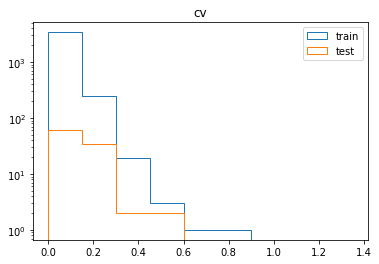

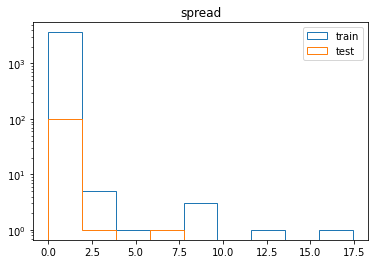

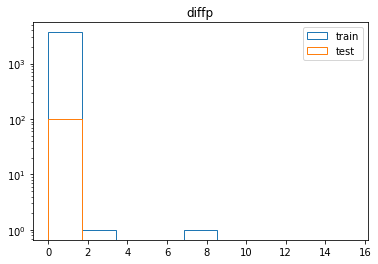

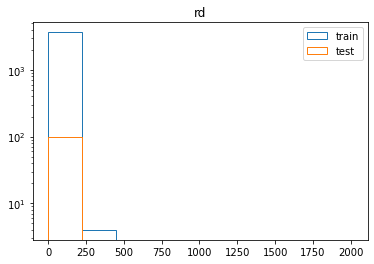

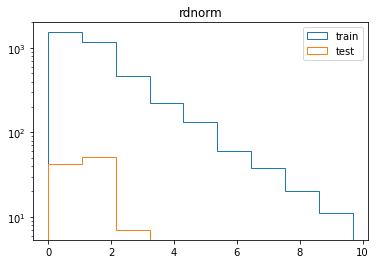

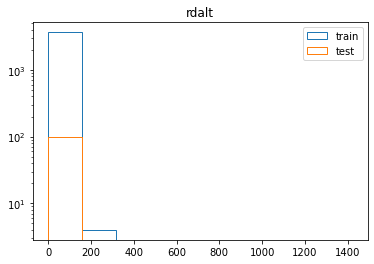

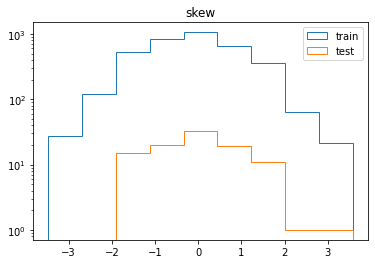

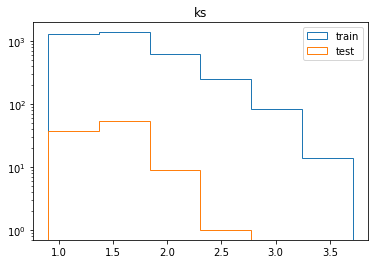

In [100]:
for marker in ['cv', 'spread', 'diffp', 'rd', 'rdnorm', 'rdalt', 'skew', 'ks']:
    plt.figure()
    plt.title(marker)
    X = pd.concat([X_train, X_test])
    mybins = np.arange(np.min(X[marker]), np.max(X[marker]),(np.abs(np.min(X[marker])) + np.max(X[marker]))/10)
    plt.hist(X_train[marker],bins = mybins,  label = "train", histtype = "step")
    plt.hist(X_test[marker],bins = mybins, label = "test", histtype = "step")
    plt.yscale("log")
    plt.legend()

## Experiment 5

In [244]:
data_names = ["ticino", "japan", "swiss", "brazil"]
test_data_names = ["US"]

features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]
conf = pd.read_json("MLresults/MLreanalysis/exp5_nbids_comp.json")
conf.head(10)

algorithm  train_f1  test_f1  train_precision  test_precision  \
0          Dummy     0.341    0.316            0.354           0.342   
1           Tree     0.797    0.739            0.892           0.827   
2         Forest     0.854    0.766            0.940           0.865   
3  GradientBoost     0.942    0.755            0.977           0.822   
4            MLP     0.735    0.729            0.832           0.825   
5       Logistic     0.611    0.609            0.679           0.682   
6            SVM     0.806    0.758            0.909           0.854   

   train_recall  test_recall  train_accuracy  test_accuracy  \
0         0.329        0.294           0.563          0.563   
1         0.721        0.669           0.874          0.838   
2         0.782        0.689           0.908          0.856   
3         0.910        0.699           0.962          0.844   
4         0.658        0.655           0.837          0.833   
5         0.555        0.554           0.757          0.756   
6         0.725        0.682           0.881          0.850   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 8, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 5, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 19, 'MLP__random_s...  
5  {'Logistic__C': 1.0, 'Logistic__random_state':...  
6  {'SVM__C': 335.9818286284, 'SVM__gamma': 0.278...

In [245]:
conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

In [246]:
X_train, X_test,y_train, y_test = prepare_data_eval(data_names, test_data_names)

  0%|          | 0/4 [00:00<?, ?it/s]

26404
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

3004
loaded test data...


In [247]:
print("Imbalance train:", y_train.sum()/len(y_train))
print("Imbalance test:", y_test.sum()/len(y_test))

Imbalance train: 0.343731778425656
Imbalance test: 0.2980877390326209


In [248]:
results_exp5, y_pred, y_pred_train = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)

/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Results removing incomplete cartels**

In [249]:
results_exp5.head()

algorithm     F1 F1_train precision precision_train recall  \
0          Dummy  0.290    0.325     0.296           0.338  0.283   
1           Tree  0.043    0.777     0.500           0.911  0.023   
2         Forest  0.021    0.810     0.167           0.928  0.011   
3  GradientBoost  0.104    0.899     0.274           0.953  0.064   
4            MLP  0.000    0.729     0.000           0.844  0.000   

  recall_train accuracy accuracy_train  \
0        0.313    0.586          0.553   
1        0.678    0.702          0.866   
2        0.718    0.688          0.884   
3        0.852    0.670          0.934   
4        0.641    0.702          0.836   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 8, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 5, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 19, 'MLP__random_s...

In [250]:
print(results_exp5.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm &    F1 & F1\_train & precision & precision\_train & recall & recall\_train & accuracy & accuracy\_train &                                             params \\
\midrule
        Dummy & 0.290 &    0.325 &     0.296 &           0.338 &  0.283 &        0.313 &    0.586 &          0.553 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree & 0.043 &    0.777 &     0.500 &           0.911 &  0.023 &        0.678 &    0.702 &          0.866 &   \{'Tree\_\_max\_depth': 6, 'Tree\_\_random\_state': 23\} \\
       Forest & 0.021 &    0.810 &     0.167 &           0.928 &  0.011 &        0.718 &    0.688 &          0.884 & \{'Forest\_\_max\_depth': 8, 'Forest\_\_random\_state'... \\
GradientBoost & 0.104 &    0.899 &     0.274 &           0.953 &  0.064 &        0.852 &    0.670 &          0.934 & \{'GradientBoost\_\_max\_depth': 5, 'GradientBoost\_... \\
          MLP & 0.000 &    0.729 &     0.000 &           0.844 &  0.0

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_91140/76322268.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_exp5.to_latex(index=False))


In [187]:
results_exp5.head()

algorithm     F1 F1_train precision precision_train recall  \
0          Dummy  0.342    0.391     0.315           0.403  0.374   
1           Tree  0.043    0.705     0.462           0.866  0.023   
2         Forest  0.046    0.760     0.184           0.899  0.026   
3  GradientBoost  0.154    0.912     0.259           0.960  0.109   
4            MLP  0.029    0.680     0.500           0.769  0.015   

  recall_train accuracy accuracy_train  \
0        0.380    0.571          0.523   
1        0.595    0.701          0.800   
2        0.659    0.675          0.832   
3        0.868    0.641          0.932   
4        0.610    0.702          0.769   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 8, 'Forest__random_state...  
3  {'GradientBoost__max_depth': 6, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...

In [188]:
y_pred.sum()/len(y_pred)

0.06299212598425197

In [189]:
y_pred_train.sum()/len(y_pred_train)

0.29594272076372313

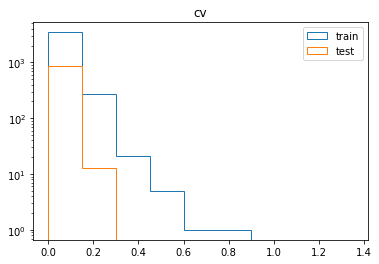

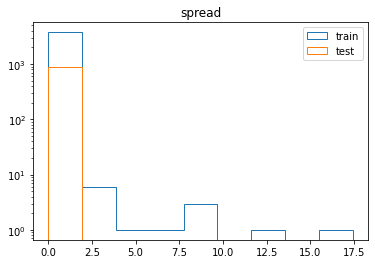

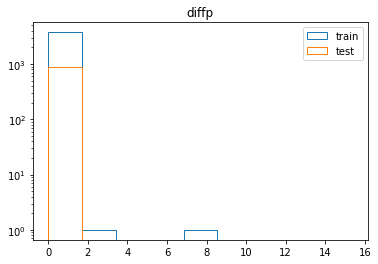

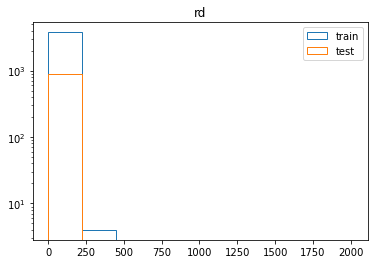

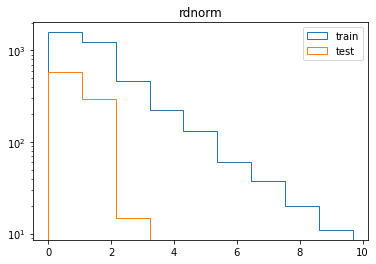

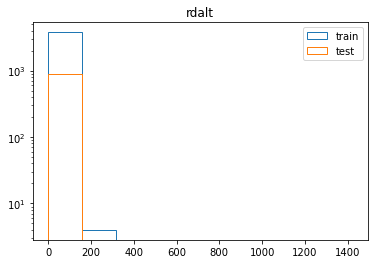

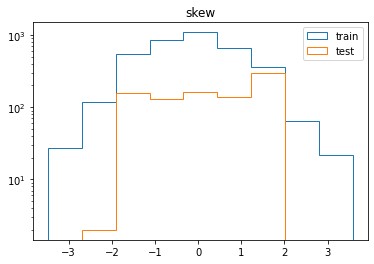

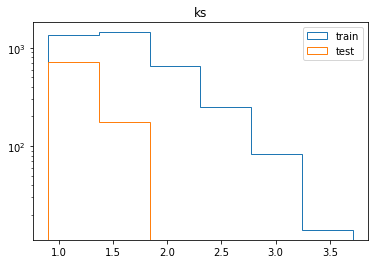

In [190]:
for marker in ['cv', 'spread', 'diffp', 'rd', 'rdnorm', 'rdalt', 'skew', 'ks']:
    plt.figure()
    plt.title(marker)
    X = pd.concat([X_train, X_test])
    mybins = np.arange(np.min(X[marker]), np.max(X[marker]),(np.abs(np.min(X[marker])) + np.max(X[marker]))/10)
    plt.hist(X_train[marker],bins = mybins,  label = "train", histtype = "step")
    plt.hist(X_test[marker],bins = mybins, label = "test", histtype = "step")
    plt.yscale("log")
    plt.legend()

## Experiment 6

In [251]:
data_names = ["ticino", "japan", "swiss", "brazil", "US"]
test_data_names = ["brazil_gaz"]

features_ML = ["cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks", "nbids"]
conf = pd.read_json("MLresults/MLreanalysis/exp6_nbids_comp.json")
conf.head(10)

algorithm  train_f1  test_f1  train_precision  test_precision  \
0          Dummy     0.337    0.303            0.350           0.330   
1           Tree     0.702    0.656            0.903           0.862   
2         Forest     0.972    0.681            1.000           0.810   
3  GradientBoost     0.998    0.682            1.000           0.783   
4            MLP     0.655    0.653            0.826           0.823   
5       Logistic     0.524    0.523            0.685           0.683   
6            SVM     0.725    0.662            0.919           0.837   

   train_recall  test_recall  train_accuracy  test_accuracy  \
0         0.326        0.280           0.572          0.569   
1         0.574        0.531           0.837          0.814   
2         0.945        0.589           0.982          0.816   
3         0.996        0.606           0.999          0.812   
4         0.543        0.545           0.809          0.808   
5         0.425        0.425           0.742          0.741   
6         0.599        0.550           0.848          0.813   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 16, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 9, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 21.5443469003, 'Logistic__rand...  
6  {'SVM__C': 1438.4498882877, 'SVM__gamma': 0.27...

In [252]:
conf_ML = [
    ('Dummy', DummyClassifier(), conf.params[conf.algorithm == "Dummy"].tolist()[0]),
    ('Tree', DecisionTreeClassifier(), conf.params[conf.algorithm == "Tree"].tolist()[0]),
    ('Forest', RandomForestClassifier(),conf.params[conf.algorithm == "Forest"].tolist()[0]),
    ('GradientBoost', GradientBoostingClassifier(), conf.params[conf.algorithm == "GradientBoost"].tolist()[0]),
    ('MLP', MLPClassifier(), conf.params[conf.algorithm == "MLP"].tolist()[0]),
    ('Logistic', LogisticRegression(), conf.params[conf.algorithm == "Logistic"].tolist()[0]),
    ('SVM', SVC(), conf.params[conf.algorithm == "SVM"].tolist()[0])
]

In [253]:
X_train, X_test,y_train, y_test = prepare_data_eval(data_names, test_data_names)

  0%|          | 0/5 [00:00<?, ?it/s]

29408
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

140043
loaded test data...


In [254]:
print("Imbalance train:", y_train.sum()/len(y_train))
print("Imbalance test:", y_test.sum()/len(y_test))

Imbalance train: 0.3343366520027784
Imbalance test: 0.4807090719499479


In [255]:
results_exp6, y_pred, y_pred_train = MLevalTUD(X_train, X_test, y_train, y_test, conf_ML)

/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [256]:
print("Imbalance train:", y_pred_train.sum()/len(y_pred_train))
print("Imbalance test:", y_pred.sum()/len(y_pred))

Imbalance train: 0.21463301690206066
Imbalance test: 0.010427528675703858


**Results without incomplete cartels**

In [257]:
results_exp6

algorithm     F1 F1_train precision precision_train recall  \
0          Dummy  0.371    0.331     0.481           0.345  0.302   
1           Tree  0.225    0.695     0.869           0.874  0.129   
2         Forest  0.042    0.949     0.769           1.000  0.022   
3  GradientBoost  0.197    0.987     0.887           1.000  0.111   
4            MLP  0.006    0.650     0.429           0.825  0.003   
5       Logistic  0.110    0.519     0.305           0.684  0.067   
6            SVM  0.006    0.714     0.150           0.913  0.003   

  recall_train accuracy accuracy_train  \
0        0.319    0.508          0.570   
1        0.577    0.572          0.831   
2        0.903    0.527          0.968   
3        0.974    0.566          0.991   
4        0.536    0.519          0.807   
5        0.418    0.478          0.741   
6        0.586    0.512          0.843   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 6, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 16, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 9, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 15, 'MLP__random_s...  
5  {'Logistic__C': 21.5443469003, 'Logistic__rand...  
6  {'SVM__C': 1438.4498882877, 'SVM__gamma': 0.27...

In [258]:
print(results_exp6.to_latex(index=False))  

\begin{tabular}{llllllllll}
\toprule
    algorithm &    F1 & F1\_train & precision & precision\_train & recall & recall\_train & accuracy & accuracy\_train &                                             params \\
\midrule
        Dummy & 0.371 &    0.331 &     0.481 &           0.345 &  0.302 &        0.319 &    0.508 &          0.570 & \{'Dummy\_\_random\_state': 23, 'Dummy\_\_strategy': ... \\
         Tree & 0.225 &    0.695 &     0.869 &           0.874 &  0.129 &        0.577 &    0.572 &          0.831 &   \{'Tree\_\_max\_depth': 6, 'Tree\_\_random\_state': 23\} \\
       Forest & 0.042 &    0.949 &     0.769 &           1.000 &  0.022 &        0.903 &    0.527 &          0.968 & \{'Forest\_\_max\_depth': 16, 'Forest\_\_random\_state... \\
GradientBoost & 0.197 &    0.987 &     0.887 &           1.000 &  0.111 &        0.974 &    0.566 &          0.991 & \{'GradientBoost\_\_max\_depth': 9, 'GradientBoost\_... \\
          MLP & 0.006 &    0.650 &     0.429 &           0.825 &  0.0

/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_91140/919756131.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_exp6.to_latex(index=False))


In [197]:
results_exp6.head(10)

algorithm     F1 F1_train precision precision_train recall  \
0          Dummy  0.395    0.371     0.468           0.382  0.342   
1           Tree  0.244    0.653     0.897           0.834  0.141   
2         Forest  0.127    0.988     0.887           1.000  0.068   
3  GradientBoost  0.176    0.955     0.909           0.992  0.098   
4            MLP  0.006    0.605     0.500           0.775  0.003   
5       Logistic  0.199    0.499     0.401           0.655  0.132   
6            SVM  0.006    0.674     0.125           0.888  0.003   

  recall_train accuracy accuracy_train  \
0        0.361    0.497          0.532   
1        0.536    0.579          0.781   
2        0.976    0.548          0.991   
3        0.920    0.562          0.967   
4        0.497    0.519          0.752   
5        0.403    0.488          0.690   
6        0.543    0.510          0.799   

                                              params  
0  {'Dummy__random_state': 23, 'Dummy__strategy':...  
1   {'Tree__max_depth': 7, 'Tree__random_state': 23}  
2  {'Forest__max_depth': 19, 'Forest__random_stat...  
3  {'GradientBoost__max_depth': 8, 'GradientBoost...  
4  {'MLP__hidden_layer_sizes': 14, 'MLP__random_s...  
5  {'Logistic__C': 59.9484250319, 'Logistic__rand...  
6  {'SVM__C': 1438.4498882877, 'SVM__gamma': 0.27...

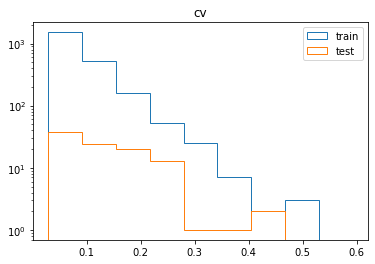

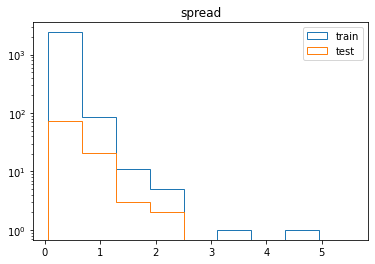

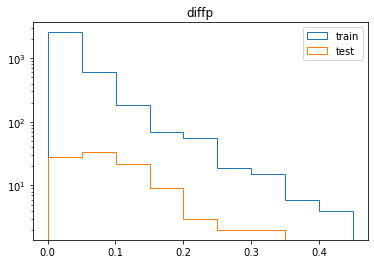

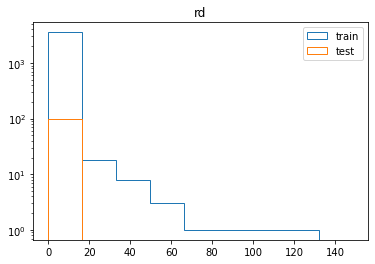

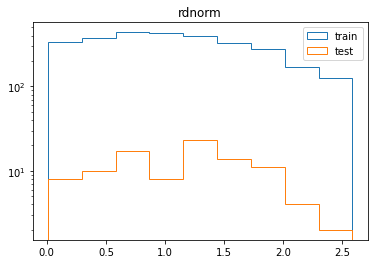

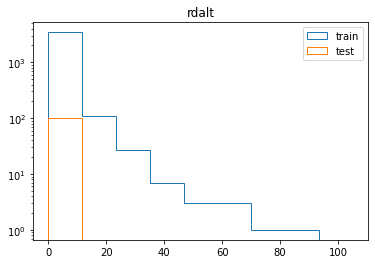

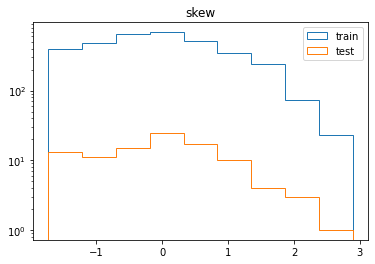

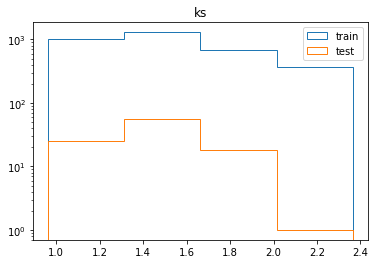

In [101]:
for marker in ['cv', 'spread', 'diffp', 'rd', 'rdnorm', 'rdalt', 'skew', 'ks']:
    plt.figure()
    plt.title(marker)
    X = pd.concat([X_train, X_test])
    mybins = np.arange(np.min(X_test[marker]), np.max(X_test[marker]),(np.abs(np.min(X_test[marker])) + np.max(X_test[marker]))/10)
    plt.hist(X_train[marker],bins = mybins,  label = "train", histtype = "step")
    plt.hist(X_test[marker],bins = mybins, label = "test", histtype = "step")
    plt.yscale("log")
    plt.legend()

# Statistik von allen Datensätzen

In [131]:
X_train.mean()

cv         0.020249
spread     0.099058
diffp      0.008528
rd         0.683802
rdnorm     4.765198
rdalt      7.010028
skew       0.049833
ks         2.694212
nbids     73.015120
dtype: float64

In [136]:
datasets = ["ticino", "japan", "brazil", "US", "swiss", "brazil_gaz"]
statistics_summary = []

for data_name in datasets:
    dataset = [data_name]
    X_train, X_test,y_train, y_test = prepare_data_eval(dataset, dataset)
    print(data_name)
    df = pd.DataFrame({"name": [data_name]})
    for marker in ['cv', 'spread', 'diffp', 'rd', 'rdnorm', 'rdalt', 'skew', 'ks', 'nbids']:
        df[f"{marker}_mean"] = [np.mean(X_train[marker])]
        df[f"{marker}_std"] = [np.std(X_train[marker])]
    statistics_summary.append(df)
df_stat = pd.concat(statistics_summary)
    
        
    

  0%|          | 0/1 [00:00<?, ?it/s]

1264
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

1264
loaded test data...
ticino


  0%|          | 0/1 [00:00<?, ?it/s]

13515
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

13515
loaded test data...
japan


  0%|          | 0/1 [00:00<?, ?it/s]

681
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

681
loaded test data...
brazil


  0%|          | 0/1 [00:00<?, ?it/s]

3004
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

3004
loaded test data...
US


  0%|          | 0/1 [00:00<?, ?it/s]

13169
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

13169
loaded test data...
swiss


  0%|          | 0/1 [00:00<?, ?it/s]

140043
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

140043
loaded test data...
brazil_gaz


In [137]:
df_stat

name   cv_mean    cv_std  spread_mean  spread_std  diffp_mean  \
0      ticino  0.044694  0.035318     0.132485    0.119534    0.051942   
0       japan  0.026063  0.080239     0.101461    0.490633    0.012510   
0      brazil  0.139365  0.094191     0.555914    0.699013    0.098810   
0          US  0.051341  0.031288     0.108009    0.070898    0.038820   
0       swiss  0.077190  0.064797     0.249335    0.611226    0.070599   
0  brazil_gaz  0.020249  0.012443     0.099058    0.067505    0.008528   

   diffp_std   rd_mean     rd_std  rdnorm_mean  rdnorm_std  rdalt_mean  \
0   0.031600  3.563111   3.497153     2.393600    1.442583    5.564075   
0   0.031104  1.460630   2.185641     2.727584    2.112440    4.603101   
0   0.077509  3.009101  16.370977     1.186519    0.637267    2.744191   
0   0.034806  3.052545   8.839142     0.861388    0.582774    2.269312   
0   0.392175  3.590901  48.416743     1.178933    0.816905    3.273017   
0   0.014133  0.683802   1.458454     4.765198    7.288480    7.010028   

   rdalt_std  skew_mean  skew_std   ks_mean    ks_std  nbids_mean  nbids_std  
0   5.971117  -0.810310  1.088468  1.759221  0.418435    6.019048   2.323712  
0   6.227933  -0.403011  1.206770  2.050709  0.485828   12.513889   3.088478  
0  11.524576   0.051508  0.980965  1.468077  0.255774    6.810000   4.160997  
0   6.389160   0.292411  1.189094  1.201641  0.171818    3.214848   0.488293  
0  34.245950   0.085404  0.989523  1.414062  0.282169    5.530869   2.400562  
0  15.911978   0.049833  1.591765  2.694212  1.131449   73.015120  73.513785

# Debugging

In [102]:
data_names = ["swiss"]
test_data_names = ["japan"]
X_train, X_test, y_train, y_test = prepare_data_eval(data_names, test_data_names)

  0%|          | 0/1 [00:00<?, ?it/s]

13169
loaded train data...


  0%|          | 0/1 [00:00<?, ?it/s]

13515
loaded test data...


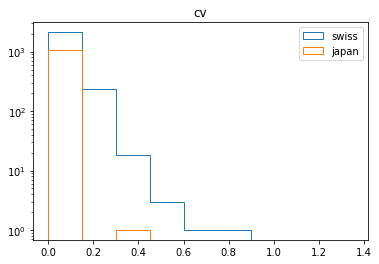

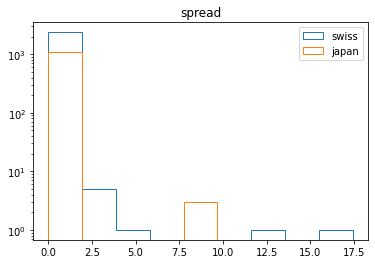

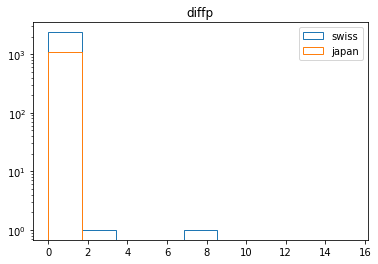

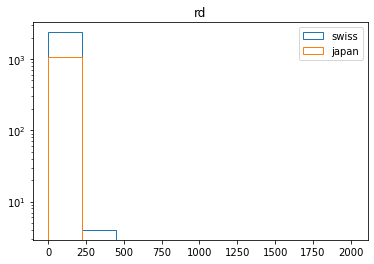

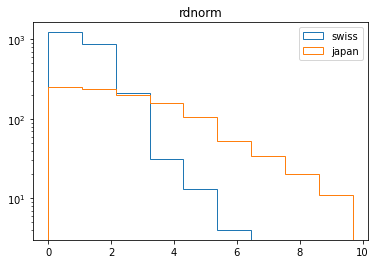

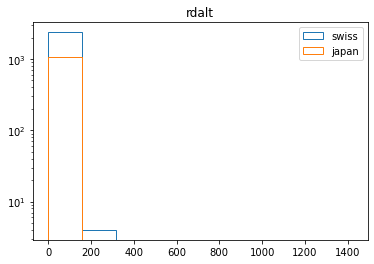

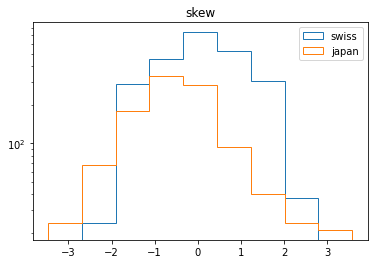

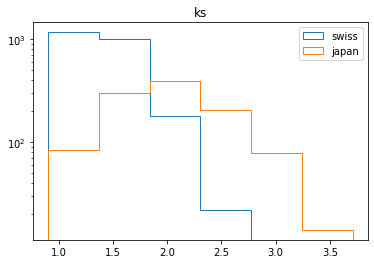

In [103]:
for marker in ['cv', 'spread', 'diffp', 'rd', 'rdnorm', 'rdalt', 'skew', 'ks']:
    plt.figure()
    plt.title(marker)
    X = pd.concat([X_train, X_test])
    mybins = np.arange(np.min(X[marker]), np.max(X[marker]),(np.abs(np.min(X[marker])) + np.max(X[marker]))/10)
    plt.hist(X_train[marker],bins = mybins,  label = "swiss", histtype = "step")
    plt.hist(X_test[marker],bins = mybins, label = "japan", histtype = "step")
    plt.yscale("log")
    plt.legend()